In [1]:
import pandas as pd

def load_data(filename='train.csv'):
    df = pd.read_csv(filename)
    return df

train = load_data()
test = load_data('test.csv')

train['train_flag'] = 1
test['train_flag'] = 0

data = pd.concat([train, test], ignore_index=True)  #data is the combined one

# Columns to drop
✅ PassengerId - No predictive value, just ID
✅ Name - Unique strings, drop after extracting Title  
✅ Ticket - Mostly unique, low value
✅ Cabin - 77% missing, drop (or create HasCabin later)

# columns to keep
❌ DON'T drop Pclass - **Strong predictor** (3rd class = lower survival)
❌ DON'T drop Age - **Fill missing** (median by Pclass/Sex), then bin into groups
❌ DON'T drop Fare - **Keep** (higher fare = higher survival chance) 
✅ Survived - Target (train only)
✅ Sex - **Best predictor** (women > men survival)
✅ SibSp - Siblings/spouses on board
✅ Parch - Parents/children on board  
✅ Embarked - Port of origin (some signal)


In [2]:

data.drop("Name", axis=1, inplace=True)
data.drop("Ticket", axis=1, inplace=True)
data.drop("Cabin", axis=1, inplace=True)
data.drop("PassengerId", axis=1, inplace=True)

In [3]:
#filling missing values in age, and then binning it so that the model better understands the data
age_median = data['Age'].median()
data['Age'].fillna(age_median, inplace=True)

bins = [0, 13, 19, 30, 50, 100]
labels = ['child', 'Teen', 'Young', 'Adult', 'Senior']
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels)

# dropping the age col
data.drop('Age', axis=1, inplace=True)

/tmp/ipykernel_219258/329678966.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(age_median, inplace=True)


count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

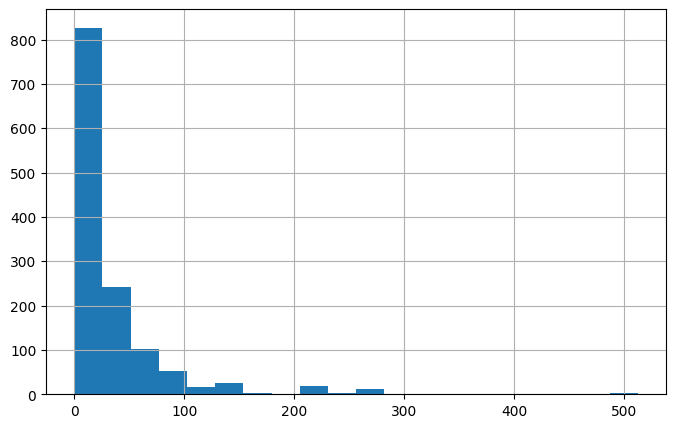

In [4]:
# binning fares but seeing data distr
data['Fare'].hist(bins=20, figsize=(8,5))
data['Fare'].describe()

In [5]:
# so from this then i div the bins to into 4 categories = low, med, high, lux
fare_mean = data['Fare'].mean()
data['Fare'].fillna(fare_mean, inplace=True)

bins = [0, 10, 30, 100, 513]
labels = ['low', 'med', 'high', 'luxury']
data['Fare_binned'] = pd.cut(data['Fare'], bins=bins, labels=labels)
data['Fare_binned'].fillna('med', inplace=True)
data.drop('Fare', axis=1, inplace=True)

/tmp/ipykernel_219258/4006193723.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Fare'].fillna(fare_mean, inplace=True)
/tmp/ipykernel_219258/4006193723.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [6]:
#taking care of more empty values
data['Embarked'].fillna('S', inplace=True)

/tmp/ipykernel_219258/3967302769.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna('S', inplace=True)


In [7]:
#creating new vars like family size and is_alone
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

In [8]:
# categorical encoding converts txt into a numerical format the model can understand
data = pd.get_dummies(data, columns=['Sex', 'Embarked', 'Age_Group', 'Fare_binned'])

In [9]:
#test train split
train_final = data[data['train_flag'] == 1].drop('train_flag', axis=1)
test_final = data[data['train_flag'] == 0].drop(['train_flag'], axis=1)



In [10]:
#creating x, and y for train(80-20) split
# Step 1: Create X, y FROM TRAIN DATA ONLY
X = train_final.drop('Survived', axis=1)  # All features
y = train_final['Survived']               # Target only

# Step 2: 80/20 SPLIT (train_test_split does this automatically)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 

In [12]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

# 3. Complete Report (precision, recall, F1 per class)
print(classification_report(y_test, y_pred))

# 4. Confusion Matrix (see true vs predicted)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8044692737430168
F1 Score: 0.7552447552447552
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       105
         1.0       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179

Confusion Matrix:
 [[90 15]
 [20 54]]
